In [5]:
print("python is working...")

python is working...


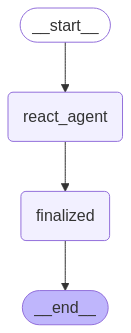

In [7]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from typing import Literal
import os
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.prebuilt.chat_agent_executor import (
    AgentState,
)
from langgraph.graph import START, END, Graph, MessagesState
from langgraph.errors import GraphInterrupt
from langgraph.types import Command
from langgraph.types import interrupt
from IPython.display import Image, display


load_dotenv()

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
memory = MemorySaver()


class AgentState(MessagesState):
    """State for our agents."""
    pass


@tool
def get_weather(location: str):
    """Use this to get weather information from a given location."""
    print("starting api call....................")
    answer = interrupt(
        # This value will be sent to the client
        # as part of the interrupt information.
        "confirm access to weather information",
    )
    if answer == "yes":
        print("get_weather...........................")
        if location.lower() in ["nyc", "new york"]:
            return "It might be cloudy in nyc"
        elif location.lower() in ["sf", "san francisco"]:
            return "It's always sunny in sf"
        else:
            raise AssertionError("Unknown Location")
    else:
        print("no permission........................")
        return "You don't have permission to access this information."


tools = [get_weather]

react_agent = create_react_agent(
    model, tools=tools
)


def finalized(agent_state: AgentState):
    """A function to handle finalization."""
    print("Finalized")
    print(agent_state)


builder = Graph()
builder.add_node("react_agent", react_agent)
builder.add_node("finalized", finalized)

builder.add_edge("react_agent", "finalized")
builder.add_edge("finalized", END)

builder.set_entry_point("react_agent")

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))
